In [20]:
## IMPORTS

# External modules
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import time
# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_absolute_percentage_error

# ignorando warnings
import warnings
warnings.filterwarnings('ignore')

# Project modules
import filter

In [21]:
## FUNCTIONS


## DATAFRAME CREATION
def get_artworks_df():
    artworks = pd.read_csv('../temporary-files/saatchi_artworks_info.csv')
    artworks.rename(columns=lambda x: x.title(), inplace=True)
    artworks.rename(columns={'Price': 'Price (US$)', 'Size': 'Size (in²)'}, inplace=True)
    artworks = calculate_area_and_price_per_area(artworks)

    artworks.dropna(subset=['Price (US$)', 'Size (in²)'])
    
    for column_name in ['Styles', 'Mediums', 'Subjects', 'Materials']:
        artworks[column_name] = artworks[column_name].apply(lambda x: [str(value.strip()) for value in x.split(',')])

    # Filter out non 'one-of-a-kind' artworks
    artworks = artworks[artworks['Original'] == 'One-of-a-kind Artwork']

    # column Artist as single-item list
    artworks['Artist'] = artworks['Artist'].apply(lambda x: [x])
    
    # Remove outliers (artworks with Price (US$/in²) in the 5% and 95% percentiles)
    artworks = artworks[artworks['Price (US$/in²)'] > artworks['Price (US$/in²)'].quantile(0.05)]
    artworks = artworks[artworks['Price (US$/in²)'] < artworks['Price (US$/in²)'].quantile(0.95)]
    return artworks


def calculate_area_and_price_per_area(dataframe):
    # Iterate over the "Size" column
    df = dataframe.copy()
    for i, size in enumerate(dataframe['Size (in²)']):
        # Extract the dimensions using regular expression
        dimensions = re.findall(r'\d+(?:\.\d+)?', size)
        if len(dimensions) >= 2:
            # Extract the width and height dimensions
            try:
                width = float(dimensions[0])
                height = float(dimensions[1])
                total_area = width * height
                df.at[i, 'Size (in²)'] = total_area
            except:
                df.at[i, 'Size (in²)'] = 'NaN'
    df['Price (US$/in²)'] = df['Price (US$)'] / df['Size (in²)']

    return df


def get_occurrence_count_on_col_dict(values):
    # Get all unique values from the column
    occurrences_counts_dict = dict(Counter(values))
    return occurrences_counts_dict


def create_segments_dataframe(segments_dfs):
    all_segments_df = pd.DataFrame(index=segments_dfs.keys(),
                                   columns=['Mean Price (US$/in²)', 'Median Price (US$/in²)',
                                            'Standard Dev Price (US$/in²)', 'Variance (US$/in²)' 'Count (#)'])
    for key, value in segments_dfs.items():
        # all_segments_df.loc[key, 'Mean Price (US$)'] = value['Price (US$)'].mean().round(0)
        # all_segments_df.loc[key, 'Median Price (US$)'] = value['Price (US$)'].median().round(0)
        # all_segments_df.loc[key, 'Standard Dev Price (US$)'] = value['Price (US$)'].std().round(0)
        # all_segments_df.loc[key, 'Variance (US$)'] = value['Price (US$)'].var().round(0)

        all_segments_df.loc[key, 'Mean Price (US$/in²)'] = value['Price (US$/in²)'].mean().round(2)
        all_segments_df.loc[key, 'Median Price (US$/in²)'] = value['Price (US$/in²)'].median().round(2)
        all_segments_df.loc[key, 'Standard Dev Price (US$/in²)'] = value['Price (US$/in²)'].std().round(2)
        all_segments_df.loc[key, 'Variance (US$/in²)'] = value['Price (US$/in²)'].var().round(2)

        all_segments_df.loc[key, 'Count (#)'] = len(value)
    all_segments_df.sort_values(by='Mean Price (US$/in²)', ascending=False, inplace=True)
    return all_segments_df


# def group_by_segments(artworks_data, column_name, column, occurrences_threshold):

#     segments_dfs = get_dfs_for_segments(filtered_artworks_data, column_name, occurrence_count_on_col_dict, occurrences_threshold)

#     create_segments_dataframe(segments_dfs)
    
#     # New dataframe for each segment
#     segments_dfs = {}
#     for key, value in occurrence_count_on_col_dict.items():
#         if value > occurrences_threshold:
#             segments_dfs[key] = dataframe[dataframe[column_name].apply(lambda x: key in x)]
#     return segments_dfs



def analyse_by_column(dataframe, column_name, threshold):
    artworks_count_by_segment = dataframe[column_name].value_counts()
    artworks_count_pct_by_segment = artworks_count_by_segment / dataframe[column_name].value_counts().sum()
    selection = artworks_count_by_segment[artworks_count_by_segment > threshold].index
    dataframe = dataframe[dataframe[column_name].isin(selection)]
    return dataframe

def compare_segments(dataframe, segments_to_compare, x_column_name, y_column_name):
    for segment in segments_to_compare:

        if segment == 'All':
            segment_df = dataframe
        else:
            segment_df = segments_dfs[segment]

        x = segment_df[[x_column_name]]
        y = segment_df[y_column_name]
        print('stats:', get_stats(segment_df, x, y))
        get_all_models(x, y)

        xlim = (0, 10000)
        ylim = (0, 40000)


def get_segments_for_column(column):
    segments = [value for sublist in column for value in sublist]
    return segments


def segment_and_clean_data(artworks_data, column_name, occurrences_threshold):
    column = artworks_data[column_name]
    
    if column_name == 'Artist':
        segments_in_column_list = artworks_data['Artist'].apply(lambda x: x[0]).to_list()
    else:
        segments_in_column_list = get_segments_for_column(column)
    occurrence_count_on_col_dict = get_occurrence_count_on_col_dict(segments_in_column_list)
    
    filtered_artworks_data = remove_empty_rows(artworks_data, column)
    filtered_artworks_data[column_name] = column
    
    segments_dfs = get_dataframes_for_segments(filtered_artworks_data, column_name, occurrence_count_on_col_dict, occurrences_threshold)
    all_segments_df = create_segments_dataframe(segments_dfs)
    
    return filtered_artworks_data, all_segments_df, segments_dfs


def remove_empty_rows(dataframe, column):
    return dataframe[column.apply(lambda x: len(x) > 0)]


def get_dataframes_for_segments(dataframe, column_name, occurrence_count_on_col_dict, occurrences_threshold):
    segments_dfs = {}
    for key, value in occurrence_count_on_col_dict.items():
        if value > occurrences_threshold:
            segments_dfs[key] = dataframe[dataframe[column_name].apply(lambda x: key in x)]
    return segments_dfs



def prepare_dataframe_dummies(artworks_data, column_name, segments_dfs):
    dummies_for_segment = artworks_data[['Price (US$)', column_name]].dropna(subset=['Price (US$)'])
    
    for key, value in segments_dfs.items():
        dummies_for_segment[key] = artworks_data[column_name].apply(lambda x: True if key in x else False)
    
    return dummies_for_segment


def get_dummies_for_all_segments(artworks, columns_names):
    dummies_for_all_segments = pd.DataFrame()

    # get one df with dummies for styles, mediums, materials and subjects
    for column_name in columns_names:
        
        if column_name == 'Artist':
            occurrences_threshold = 5
        else:
            occurrences_threshold = artworks.shape[0] / 100
        
        segments_dfs = segment_and_clean_data(artworks, column_name, occurrences_threshold)[2]
        dummies_for_segment = prepare_dataframe_dummies(artworks, column_name, segments_dfs)
        # concat dummies_for_segment to dummies_for_all_segments
        dummies_for_all_segments = pd.concat([dummies_for_all_segments, dummies_for_segment], axis=1)


    dummies_for_all_segments.drop(columns=columns_names, inplace=True)

    # add price, size, country
    columns_to_add = ['Size (in²)', 'Price (US$)']
    for column_name in columns_to_add:
        dummies_for_all_segments[column_name] = artworks[column_name]

    return dummies_for_all_segments


def analyse_by_segments(artworks, column_name, sort_by, min_frequency):
    artworks_by_segment = analyse_by_column(artworks, column_name, min_frequency)
    # Get mean price per segment as 'Mean Price' column
    mean_price_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$)': 'mean'})
    median_price_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$)': 'median'})
    mean_price_per_in_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$/in²)': 'mean'})
    median_price_per_in_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$/in²)': 'median'})
    col_analysis_by_segment = pd.concat([mean_price_by_segment, median_price_by_segment, mean_price_per_in_by_segment, median_price_per_in_by_segment, artworks[column_name].value_counts()], axis=1)
    col_analysis_by_segment.columns = ['Mean Price (US$)', 'Median Price (US$)','Mean Price (US$/in²)', 'Median Price (US$/in²)', 'Count (#)']
    # filter out segments with less than [min_frequency] artworks
    col_analysis_by_segment = col_analysis_by_segment[col_analysis_by_segment['Count (#)'] > min_frequency]

    col_analysis_by_segment.sort_values(by=sort_by, ascending=False, inplace=True)
    col_analysis_by_segment = col_analysis_by_segment.dropna()

    return col_analysis_by_segment


def get_descriptive_stats_of_columns(dataframe, columns_names, segment=""):

    descriptive_stats_df = pd.DataFrame()

    for column_name in columns_names:
        column = dataframe[column_name]
        
        descriptive_stats_df.loc['max', column_name] = column.max()
        descriptive_stats_df.loc['min', column_name] = column.min()
        descriptive_stats_df.loc['mean', column_name] = column.mean()
        descriptive_stats_df.loc['median', column_name] = column.median()
        descriptive_stats_df.loc['stdev', column_name] = column.std()
        descriptive_stats_df.loc['var', column_name] = column.var()

        modified_column_name = column_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
        descriptive_stats_df.to_csv(f'data_files/descriptive_analysis_{modified_column_name}{segment}.csv', index=True)
        plot_histogram(column, f'Artworks by {column_name}', column_name, 'Frequency')

    return descriptive_stats_df



def case_study(dataframe, indices_lists, segments_names):
    for indices_list, segment in zip(indices_lists, segments_names):
        size_dummies = dataframe.loc[indices_list]
        size_dummies['Predicted Price (US$)'] = size_dummies['Predicted Price (US$)'].astype(float)

        print(f'\n\n{segment} size artworks')

        descriptive_df_segments = get_descriptive_stats_of_columns(size_dummies, ['Residual Price (%)', 'Residual Price (US$)'], f'_{segment}')
        print(descriptive_df_segments)

In [22]:
## MODELS


def get_stats(x, y):
    stats = {}
    for variable in [x, y]:
        max_variable = round(max(variable), 2)
        min_variable = round(min(variable), 2)
        mean_variable = round(variable.mean(), 2)
        median_variable = round(variable.median(), 2)
        stats_variable = {'Max': max_variable, 'Min': min_variable, 'Mean': mean_variable, 'Median': median_variable}
        # add stats_variable to stats
        stats[variable] = stats_variable
    return stats


## GET MODELS

def get_decision_tree(X_train, y_train):
    decision_tree = DecisionTreeRegressor(random_state=42)
    decision_tree.fit(X_train, y_train)
    return decision_tree

def get_linear_regression(X_train, y_train):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    return linear_regression

def get_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(random_state=1)
    rf_model.fit(X_train, y_train)
    return rf_model

def get_gradient_boosting(X_train, y_train):
    # get gradient boosting model
    gb_model = GradientBoostingRegressor(random_state=1)
    gb_model.fit(X_train, y_train)
    return gb_model

# gives a dataframe taking models as columns and score as rows
def get_all_models(x_train, x_test, y_train, y_test):
    
    models = {'Linear regression': get_linear_regression(x_train, y_train),
              'Decision tree': get_decision_tree(x_train, y_train),
              'Random forest': get_random_forest(x_train, y_train),
              'Gradient boosting': get_gradient_boosting(x_train, y_train)}
    
    models_df = pd.DataFrame(columns=models.keys())
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        p = x_test.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mean_error = mean_absolute_error(y_test, y_pred)
        median_error = median_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        pearson = np.corrcoef(y_test.to_numpy(), y_pred)[0, 1]

        models_df.loc['R² Score', model_name] = r2
        models_df.loc['Adjusted R² Score', model_name] = adj_r2
        models_df.loc['Pearson Correl Predicted-Actual', model_name] = pearson
        models_df.loc['Mean Absolute Error', model_name] = mean_error
        models_df.loc['Median Absolute Error', model_name] = median_error
        models_df.loc['Mean Squared Error', model_name] = mse

        # Round values
        models_df = models_df.round(2)

    return models_df, models

In [23]:
## CHARTS

dark_green_color_code = '#195921'
gold_color_code = '#FFD700'
black_color_code = '#000000'
salmon_color_code = '#FA8072'

def plot_segment_chart(dataframe, segments_column_name, bar_column_name, line_columns_names, title):
    bar_color_code = dark_green_color_code
    line_colors_codes = [gold_color_code, black_color_code]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    ax1.bar(dataframe.index, dataframe[bar_column_name], color=bar_color_code)
    for line_column_name in line_columns_names:
        ax2.plot(dataframe.index, dataframe[line_column_name], label=line_column_name, color=line_colors_codes.pop(0))
    ax2.legend()
    ax1.set_xticklabels(dataframe.index, rotation=90)
    ax1.set_ylabel(bar_column_name)
    ax2.set_ylabel(str(line_columns_names))
    ax1.set_xlabel(segments_column_name)
    ax1.set_title(title)
    # beautify and enhance readability of the chart
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax1.tick_params(axis='x', which='major', labelsize=8)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax2.tick_params(axis='y', which='major', labelsize=8)
    plt.savefig('./charts/' + title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') + '.png')
    plt.show()


def plot_scatter(dataframe, x_column_name, y_column_name, title, log=False):
    if log:
        x = np.log(dataframe[x_column_name].astype(float))
        y = np.log(dataframe[y_column_name].astype(float))
    else:
        x = dataframe[x_column_name].astype(float)
        y = dataframe[y_column_name].astype(float)

    plt.figure()
    plt.title(title)
    plt.xlabel(x_column_name)
    plt.ylabel(y_column_name)
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
    
    plt.scatter(x=x, y=y, c=dark_green_color_code)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),c=salmon_color_code)
    plt.savefig('./charts/' + title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') + '.png')
    plt.show()


def plot_histogram(column, title, x_label, y_label, bins=50):
    column.hist(bins=bins, color=dark_green_color_code)
    # line of the mean
    plt.axvline(column.mean(), color='gold', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.savefig('./charts/' + title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') + '.png')
    plt.show()

In [24]:
## INITIALIZE DATAFRAME

artworks = get_artworks_df()

# FILTER BY PERCENTILE between 0.25 and 0.75
# get artworks between 0.25 and 0.75 quantile
# artworks = artworks[artworks['Size (in²)'] > artworks['Size (in²)'].quantile(0.75)]

quantile = ''

In [25]:
# get untitled artworks
artworks[artworks['Title'].str.lower() == 'untitled']

,Title,Packaging,Collage,Multi-Paneled Collage,Mediums,Ready To Hang,Original,Digital,Country,Multi-Paneled Mixed Media,...,Customs,Views,Description,Frame,Printmaking,Multi-Paneled Drawing,Painting,Drawing,Size (in²),Price (US$/in²)
417,Untitled,Ships in a Box,NaN,NaN,[Oil],Not applicable,One-of-a-kind Artwork,NaN,Qatar,NaN,...,NaN,NaN,This painting is a series on Fashion ..this pa...,Not Framed,NaN,NaN,Oil on Wood,NaN,573.6,1.743375
517,Untitled,Ships in a Box,NaN,NaN,[Acrylic],Not applicable,One-of-a-kind Artwork,NaN,Netherlands,NaN,...,NaN,NaN,Abstract artwork in acrylic and oil bar on can...,Not Framed,NaN,NaN,Acrylic on Canvas,NaN,1241.1,1.99017
546,Untitled,Ships in a Box,NaN,NaN,[Monotype],Not applicable,One-of-a-kind Artwork,NaN,Japan,NaN,...,NaN,NaN,Abstract acrylic monotype on drawing paper (tr...,Not Framed,Monotype on Paper,NaN,NaN,NaN,147.96,3.784807
633,Untitled,Ships in a Box,Paper on Cardboard,NaN,"[Paper, Photo, Paint, Charcoal, Pencil]",Not applicable,One-of-a-kind Artwork,NaN,France,NaN,...,NaN,NaN,"handmade paper collage on book cover, created ...",Not Framed,NaN,NaN,NaN,NaN,57.34,3.836763
960,Untitled,Ships in a Box,Paper on Wood,NaN,"[Paper, Paint, Pencil, Marker, Plastic]",Not applicable,One-of-a-kind Artwork,NaN,France,NaN,...,NaN,NaN,"handmade paper collage on wood board, created ...",Not Framed,NaN,NaN,NaN,NaN,59.4,7.239057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15261,Untitled,Ships Rolled in a Tube,NaN,NaN,"[Acrylic, Ink]",No,One-of-a-kind Artwork,NaN,United Kingdom,NaN,...,Shipments from United Kingdom may experience d...,NaN,"Painting: Acrylic, Ink, Black & White, Paint o...",Not Framed,NaN,NaN,Acrylic on Paper,NaN,813.6,0.872665
15355,Untitled,Ships in a Box,Paper on Cardboard,NaN,"[Paper, Photo, Paint, Pencil, Gouache]",Not applicable,One-of-a-kind Artwork,NaN,France,NaN,...,NaN,NaN,"handmade paper collage on book cover, created ...",Not Framed,NaN,NaN,NaN,NaN,43.99,3.409866
15715,untitled,Ships Rolled in a Tube,NaN,NaN,"[Oil, Ink]",No,One-of-a-kind Artwork,NaN,United Kingdom,NaN,...,Shipments from Poland may experience delays du...,NaN,Mixed media painting on unstretched canvas. Th...,Not Framed,NaN,NaN,Oil on Canvas,NaN,2911.9,0.686493
15767,Untitled,Ships in a Box,NaN,NaN,[Oil],Not applicable,One-of-a-kind Artwork,NaN,Colombia,NaN,...,Shipments from Colombia may experience delays ...,NaN,Untitled Oil on canvas 80 cm x 70 cm 2023 ...,Not Framed,NaN,NaN,Oil on Canvas,NaN,866.25,4.155844


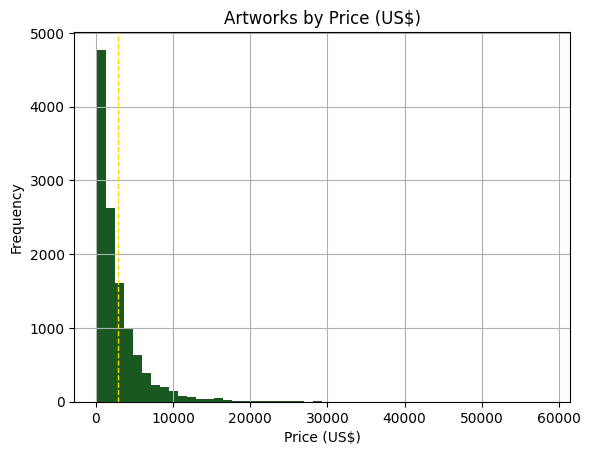

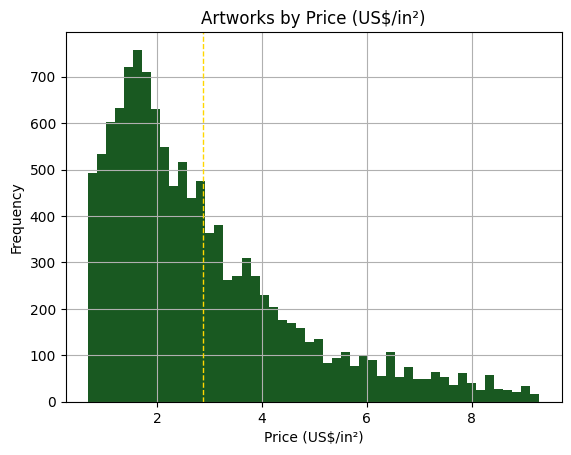

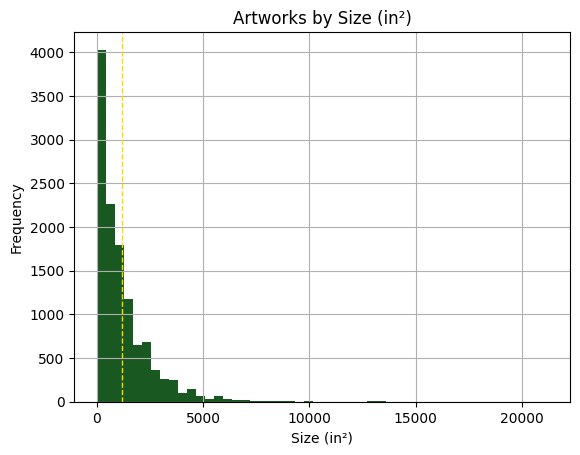

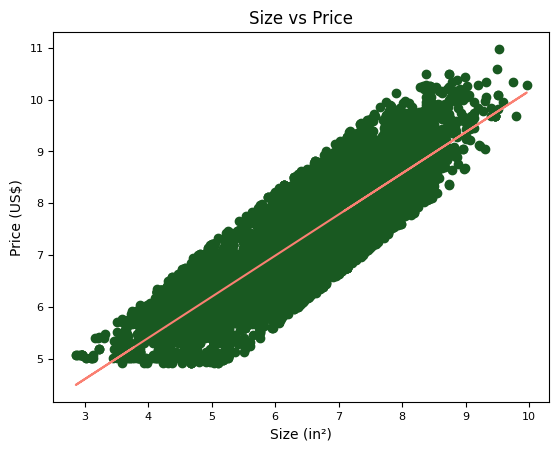

,Price (US$),Price (US$/in²),Size (in²)
max,5.855000e+04,9.285972,2.120664e+04
min,1.350000e+02,0.681250,1.749000e+01
mean,2.851584e+03,2.868842,1.215049e+03
median,1.721000e+03,2.356997,7.745400e+02
stdev,3.428282e+03,1.799354,1.343444e+03
var,1.175312e+07,3.237675,1.804842e+06


In [26]:
## DESCRIPTIVE STATISTICS OF COLUMNS PRICE, PRICE PER INCH AND SIZE


columns_names = ['Price (US$)', 'Price (US$/in²)', 'Size (in²)']

descriptive_stats_df = get_descriptive_stats_of_columns(artworks, columns_names)

## SCATTER PLOT PRICE VS SIZE
plot_scatter(artworks, 'Size (in²)', 'Price (US$)', 'Size vs Price', True)

descriptive_stats_df.to_csv('data_files/descriptive_stats.csv', index=True)
descriptive_stats_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


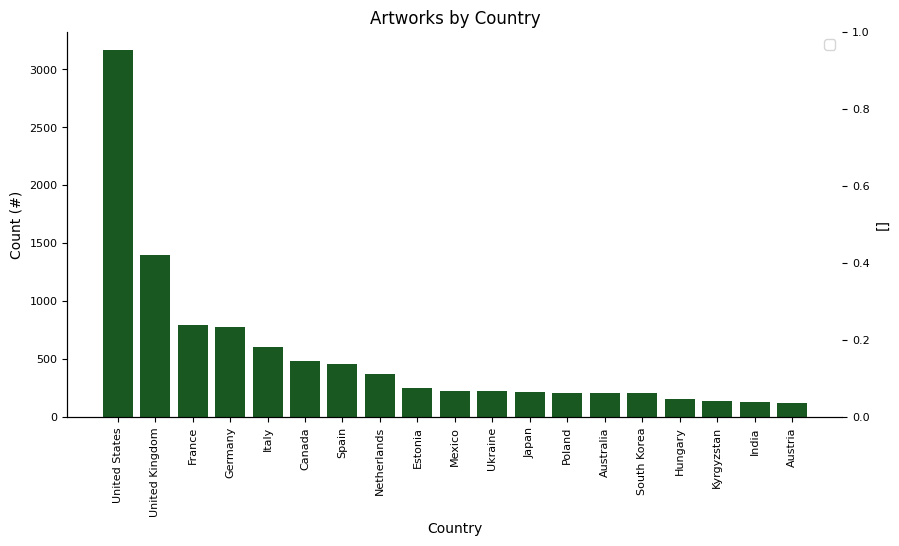

,Mean Price (US$),Median Price (US$),Mean Price (US$/in²),Median Price (US$/in²),Count (#)
Country,,,,,
United States,2884.773000,1500.0,2.872959,2.413127,3163
United Kingdom,2476.196862,1582.5,3.503222,2.892039,1402
France,2279.108040,1500.0,2.629357,2.325492,796
Germany,4529.867609,3070.0,2.832167,2.232329,778
Italy,2579.246689,1895.0,3.346735,2.675585,604
Canada,2640.272917,1805.0,2.392322,1.976374,480
Spain,2619.427948,1600.0,2.915871,2.375995,458
Netherlands,3244.123989,2720.0,2.70312,2.177499,371
Estonia,5136.431452,4070.0,3.984395,3.834694,248


In [27]:
## DESCRIPTIVE STATISTICS OF COUNTRY COLUMN

column_name1 = 'Country'
sort_by1 = 'Count (#)'
min_frequency1 = artworks.shape[0] * 0.01

col_analysis_by_segment = analyse_by_segments(artworks, column_name1, sort_by1, min_frequency1)
plot_segment_chart(col_analysis_by_segment, column_name1, 'Count (#)', [], 'Artworks by ' + column_name1)
col_analysis_by_segment

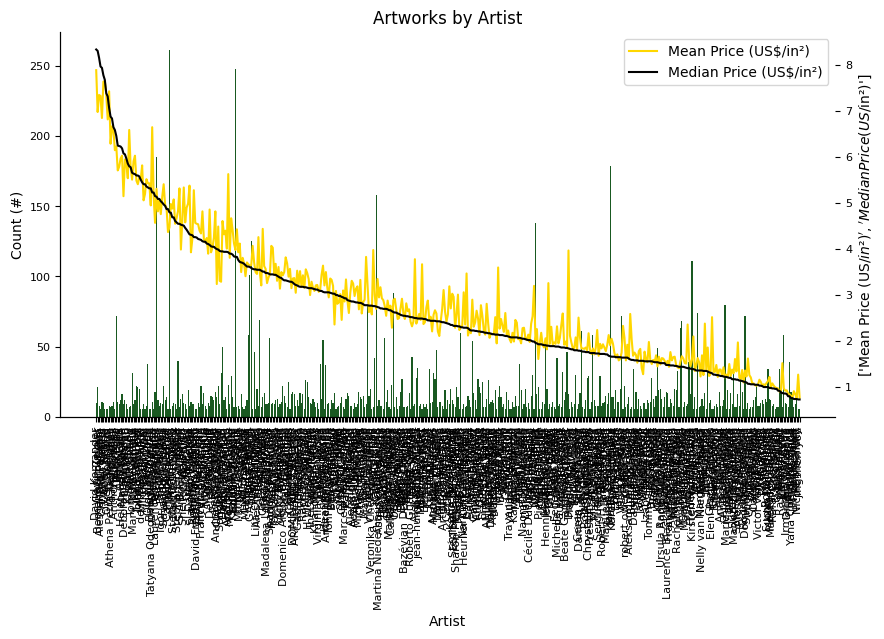

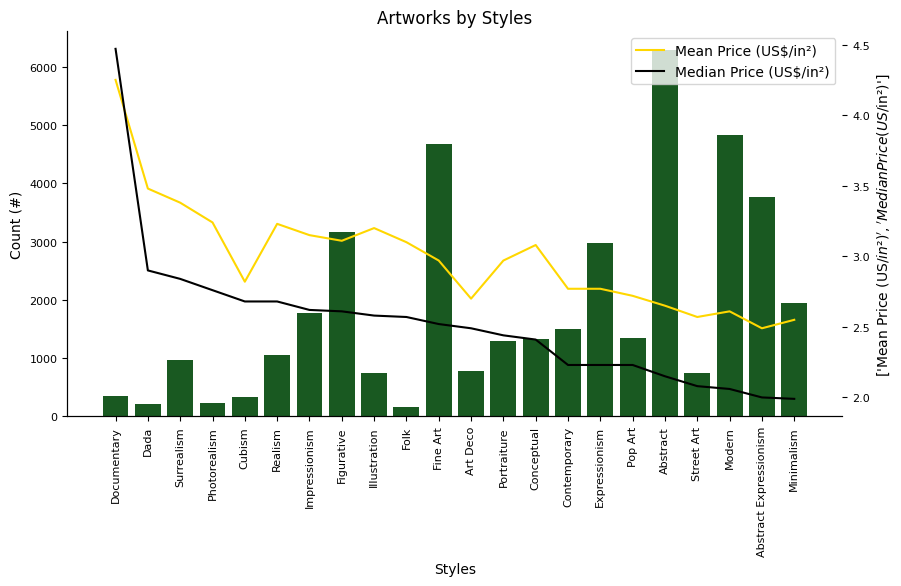

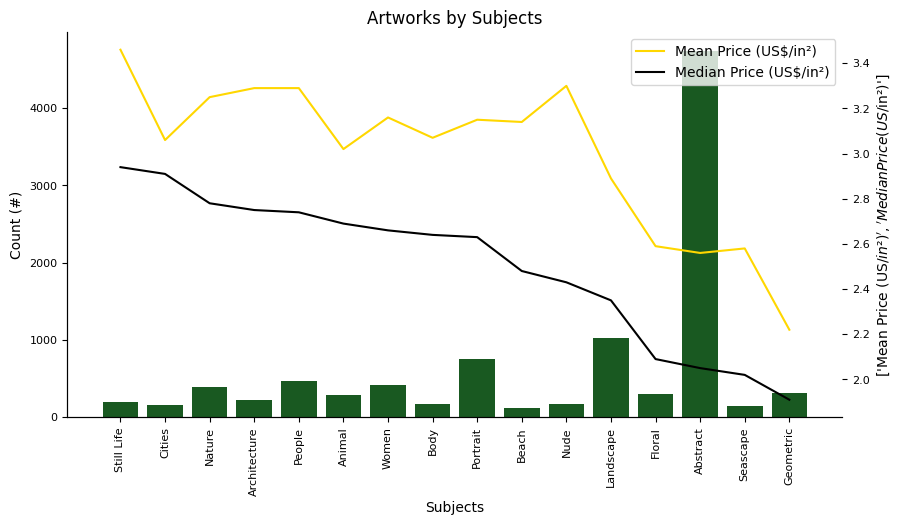

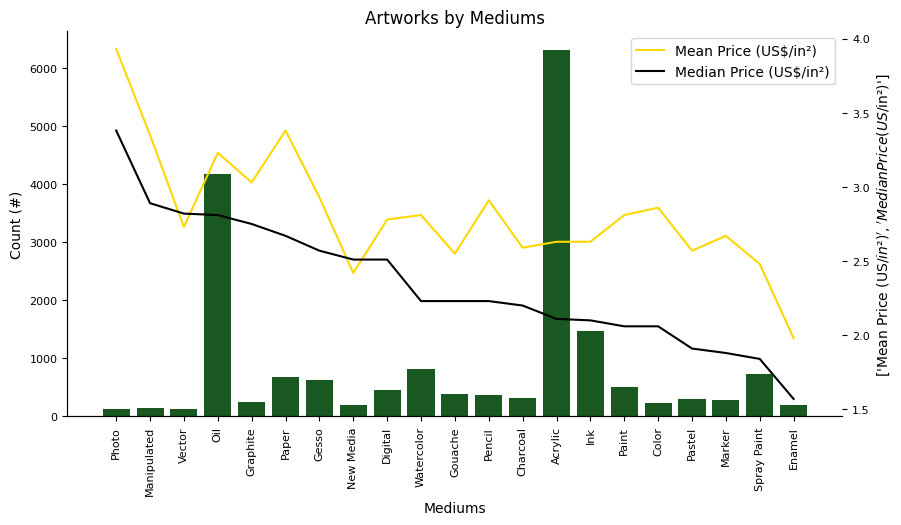

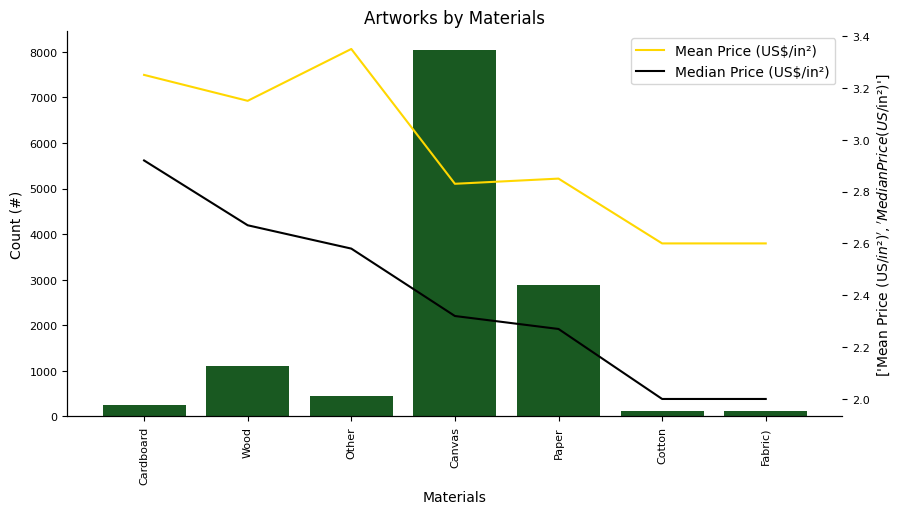

In [28]:
## DESCRIPTIVE STATISTICS OF CATEGORIES (ARTIST, STYLES, SUBJECTS, MEDIUMS, MATERIALS)

categories_columns_list = ['Artist', 'Styles', 'Subjects', 'Mediums', 'Materials']

sort_by = 'Median Price (US$/in²)'

categories_dfs = {}
categories_models_metrics_df = {}
categories_models = {}

for column_name in categories_columns_list:

    if column_name == 'Artist':
        occurrences_threshold = 5
    else:
        occurrences_threshold = artworks.shape[0]/100

    column = artworks[column_name]
    filtered_artworks_data, all_segments_from_category_df, segments_dfs = segment_and_clean_data(artworks, column_name, occurrences_threshold)

    all_segments_from_category_df.drop('Variance (US$/in²)Count (#)', axis=1, inplace=True)
    all_segments_from_category_df.sort_values(by=sort_by, ascending=False, inplace=True)

    plot_segment_chart(all_segments_from_category_df, column_name, 'Count (#)', ['Mean Price (US$/in²)', 'Median Price (US$/in²)'], 'Artworks by ' + column_name)
    categories_dfs[column_name] = all_segments_from_category_df

    # save all_segments_from_category_df as csv
    all_segments_from_category_df.to_csv(f'data_files/descriptive_analysis_{column_name}{quantile}.csv', index=True)

In [29]:
## APPLYING MODELS TO SIZE AND CATEGORIES' DUMMIES

artworks_for_models = artworks[['Artist', 'Styles', 'Subjects', 'Mediums', 'Materials', 'Size (in²)', 'Price (US$)', 'Price (US$/in²)']]

train_data, test_data = train_test_split(artworks_for_models, test_size=0.2, random_state=42)


train_dummies = get_dummies_for_all_segments(train_data, categories_columns_list)
test_dummies = get_dummies_for_all_segments(test_data, categories_columns_list)

# Deal with differences in columns between train and test
missing_cols = set(train_dummies.columns) - set(test_dummies.columns)
for missing_col in missing_cols:
    test_dummies[missing_col] = False
# Ensure the order of column in the test set is in the same order than in train set
test_dummies = test_dummies[train_dummies.columns]

# eliminate duplicate columns
train_dummies = train_dummies.loc[:,~train_dummies.columns.duplicated()]
test_dummies = test_dummies.loc[:,~test_dummies.columns.duplicated()]

x_train = train_dummies.drop(columns=['Price (US$)'])
y_train = train_dummies['Price (US$)']

x_test = test_dummies.drop(columns=['Price (US$)'])
y_test = test_data['Price (US$)']


models_metrics_df, models = get_all_models(x_train, x_test, y_train, y_test)
# # save models_metrics_df as csv
models_metrics_df.to_csv(f'./data_files/models_metrics_df{quantile}.csv', index=True)

models_metrics_df

,Linear regression,Decision tree,Random forest,Gradient boosting
R² Score,0.653133,0.4864,0.681509,0.67381
Adjusted R² Score,0.572964,0.367694,0.607897,0.598419
Pearson Correl Predicted-Actual,0.810237,0.737162,0.826371,0.820981
Mean Absolute Error,1070.683016,1157.324047,930.109658,1049.568845
Median Absolute Error,586.487047,412.5,400.220833,567.203371
Mean Squared Error,3547292.853703,5252422.289871,3257106.341003,3335838.643188


In [30]:
## FEATURE IMPORTANCES

# Select model with lowest MAE
model_name = models_metrics_df.sort_values('Mean Absolute Error', axis=1, ascending=True).columns[0]
model = models[model_name]

feature_importances_df = pd.DataFrame(model.feature_importances_,
                                      index = x_test.columns,
                                        columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)

In [31]:
## CATEGORY-CLUSTERED FEATURE IMPORTANCES

# {Category: Segment} dictionay
category_segments_dict = {}
for column_name in categories_columns_list:
    categories = categories_dfs[column_name].index.tolist()
    category_segments_dict[column_name] = categories

# Invert dictionary: {Segment: Category}
segment_categories_dict = {}
segment_categories_dict['Size (in²)'] = 'Size (in²)'
for category, segments in category_segments_dict.items():
    for segment in segments:
        segment_categories_dict[segment] = category

feature_importances_df['Category'] = feature_importances_df.index.map(segment_categories_dict)

feature_importances_df

clustered_feature_importances_df = feature_importances_df.groupby('Category').sum().sort_values('Feature Importance', ascending=False).head(10)

# save to csv
feature_importances_df.to_csv(f'data_files/model_feature_importances{quantile}.csv')
clustered_feature_importances_df.to_csv(f'data_files/model_clustered_feature_importances{quantile}.csv')
clustered_feature_importances_df

,Feature Importance
Category,
Size (in²),0.668950
Artist,0.141801
Styles,0.106098
Mediums,0.042199
Subjects,0.028689
Materials,0.011803


In [32]:
## INCLUDE PREDICTIONS AND RESIDUALS IN TEST DATA

test_dummies
y_pred = model.predict(x_test)

test_dummies['Predicted Price (US$)'] = y_pred
test_dummies['Residual Price (US$)'] = test_dummies['Predicted Price (US$)'] - test_dummies['Price (US$)']
test_dummies['Residual Price (%)'] = test_dummies['Residual Price (US$)'] / test_dummies['Price (US$)']
test_dummies['Price (US$/in²)'] = test_dummies['Price (US$)'] / test_dummies['Size (in²)']

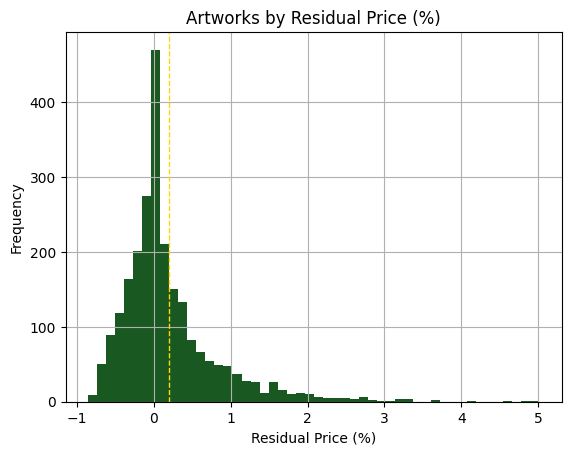

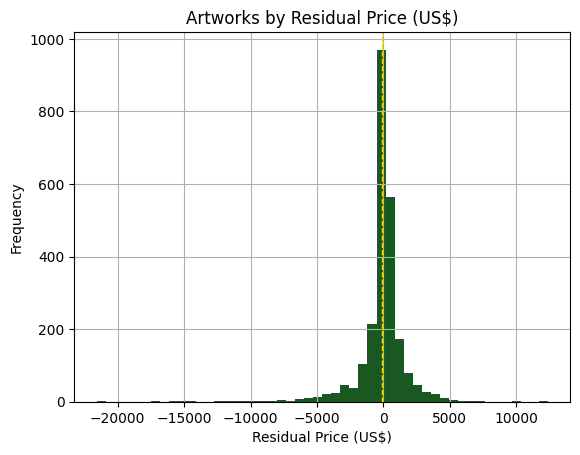

In [33]:
## DISTRIBUTION OF RESIDUALS
segment = ""
descriptive_df_size_segments = get_descriptive_stats_of_columns(test_dummies, ['Residual Price (%)', 'Residual Price (US$)'], f'_{segment}')



big size artworks


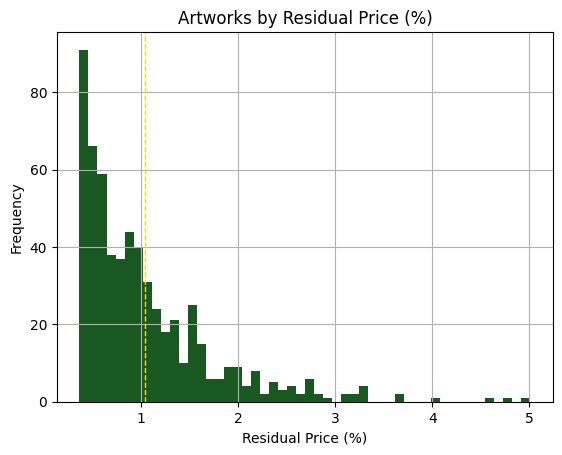

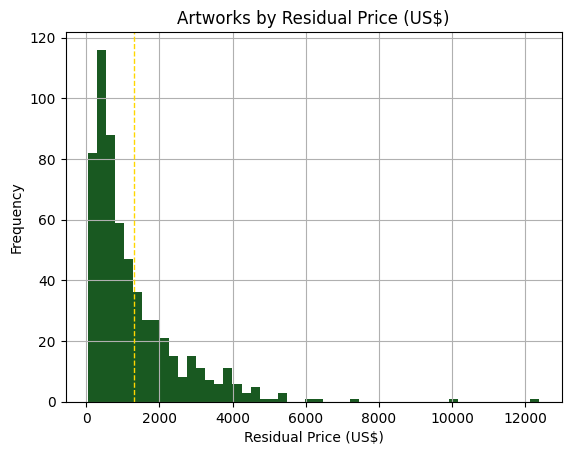

        Residual Price (%)  Residual Price (US$)
max               5.010611          1.237879e+04
min               0.367563          5.659111e+01
mean              1.042128          1.294910e+03
median            0.864188          8.389175e+02
stdev             0.695612          1.292152e+03
var               0.483876          1.669657e+06


medium size artworks


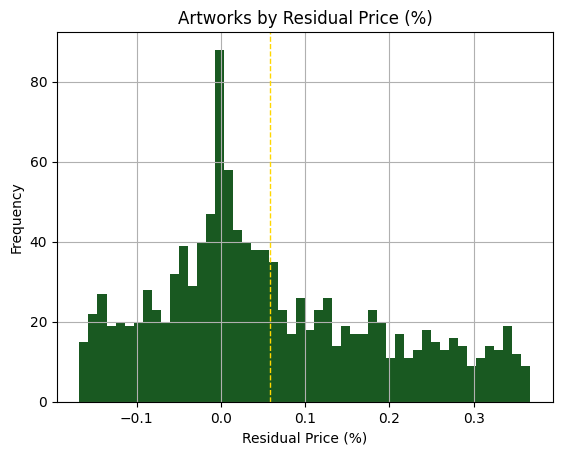

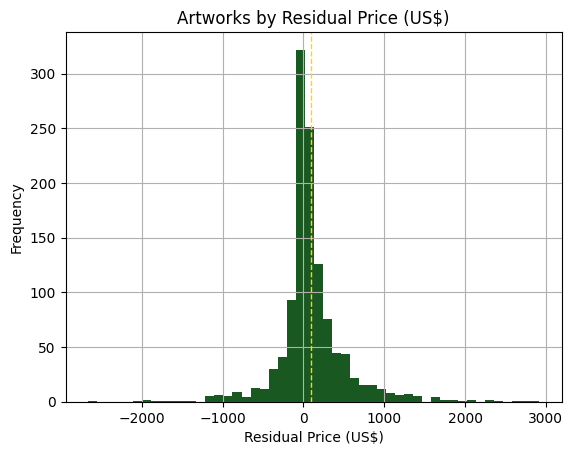

        Residual Price (%)  Residual Price (US$)
max               0.367342           2916.942381
min              -0.168122          -2663.900000
mean              0.058216             98.026801
median            0.027090             33.494286
stdev             0.133309            454.506003
var               0.017771         206575.706532


small size artworks


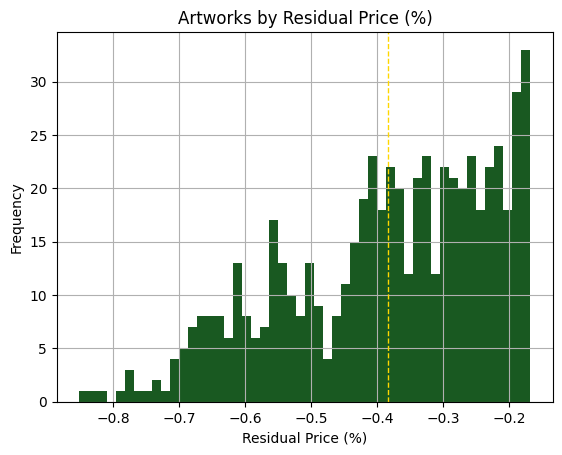

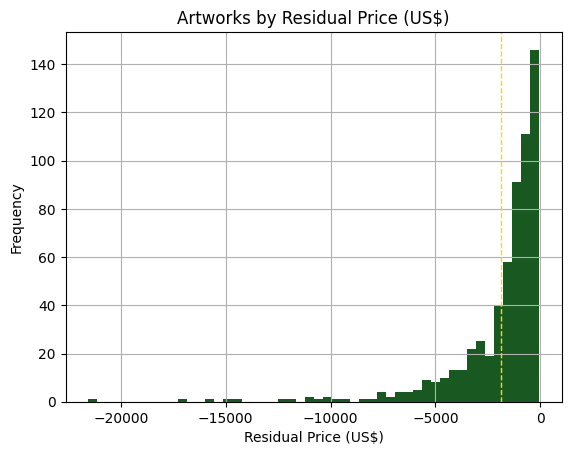

        Residual Price (%)  Residual Price (US$)
max              -0.168176         -5.227500e+01
min              -0.851198         -2.156045e+04
mean             -0.383697         -1.891889e+03
median           -0.361506         -1.130613e+03
stdev             0.155903          2.381766e+03
var               0.024306          5.672807e+06


In [34]:
## CASE STUDIES: LARGE RESIDUALS

segment = "large_residuals"

# get 0.75 quantile of residuals
q75 = test_dummies['Residual Price (%)'].quantile(0.75)
q25 = test_dummies['Residual Price (%)'].quantile(0.25)
# get the artworks with index in large_residual_indices
large_residual_indices = test_dummies[test_dummies['Residual Price (%)'] > q75].index
small_residual_indices = test_dummies[test_dummies['Residual Price (%)'] < q25].index
medium_residual_indices = test_dummies[(test_dummies['Residual Price (%)'] > q25) & (test_dummies['Residual Price (%)'] < q75)].index

residual_indices_lists = [large_residual_indices, medium_residual_indices, small_residual_indices]
resisual_names = ['big', 'medium', 'small']

case_study(test_dummies, residual_indices_lists, resisual_names)

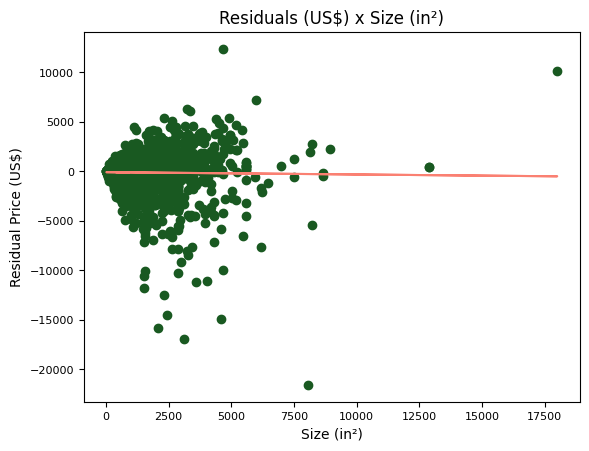

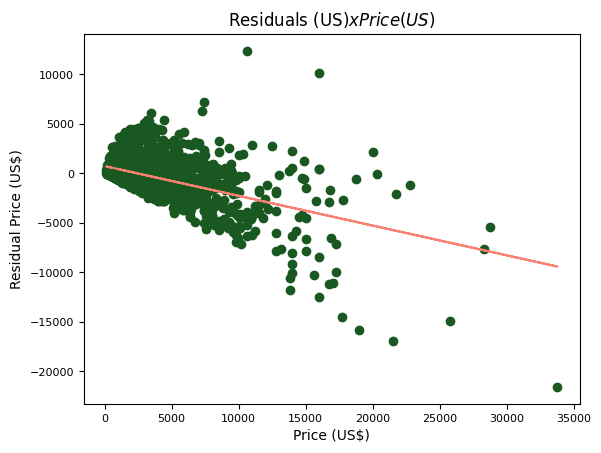

In [35]:
# plot residuals (%) x size
residuals_analysis_columns_names = ['Size (in²)', 'Price (US$)']

for column_name in residuals_analysis_columns_names:
    plot_scatter(test_dummies, column_name, 'Residual Price (US$)', f'Residuals (US$) x {column_name}')



Big size artworks


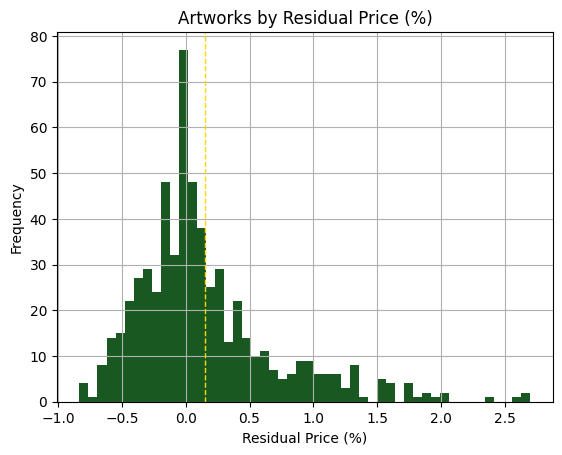

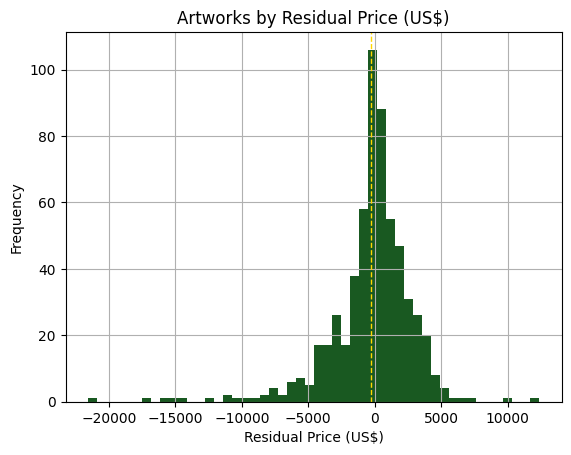

        Residual Price (%)  Residual Price (US$)
max               2.698006          1.237879e+04
min              -0.831503         -2.156045e+04
mean              0.148479         -2.379645e+02
median            0.015119          7.093958e+01
stdev             0.559563          3.108664e+03
var               0.313110          9.663792e+06


Medium size artworks


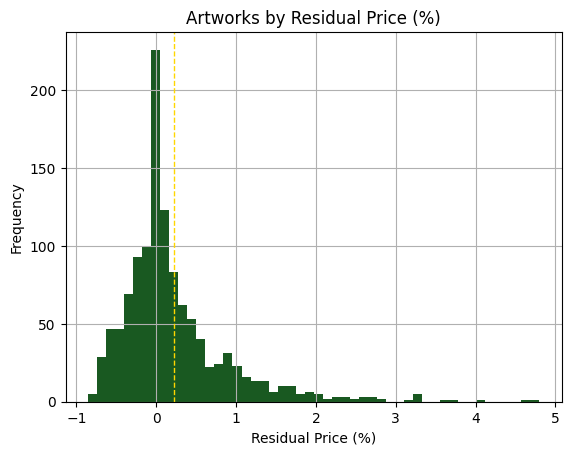

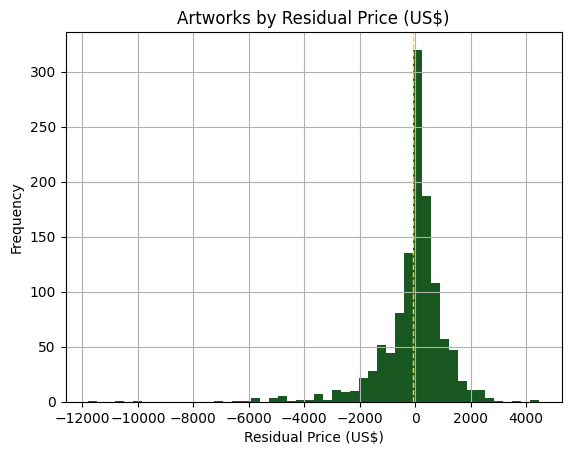

        Residual Price (%)  Residual Price (US$)
max               4.795076          4.465337e+03
min              -0.851198         -1.178909e+04
mean              0.220420         -8.526888e+01
median            0.039300          5.952000e+01
stdev             0.685500          1.271340e+03
var               0.469910          1.616305e+06


Small size artworks


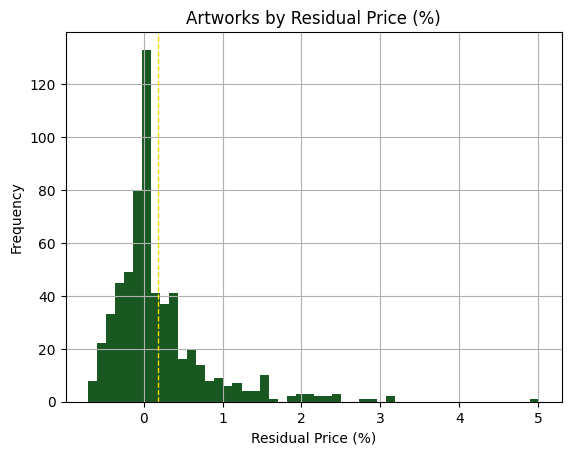

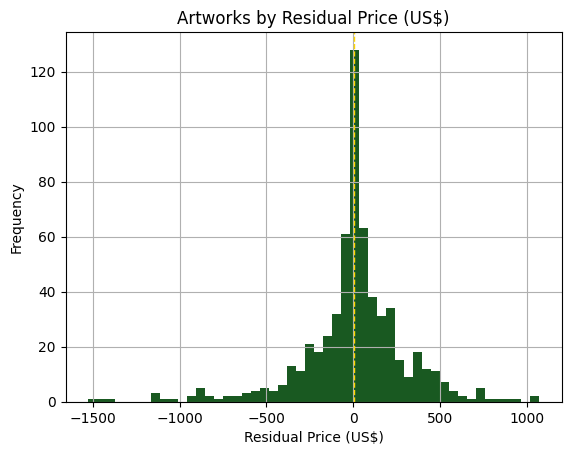

        Residual Price (%)  Residual Price (US$)
max               5.010611           1071.270000
min              -0.701930          -1526.051944
mean              0.186537              5.752894
median            0.021675              5.890000
stdev             0.617176            307.763657
var               0.380907          94718.468391


In [36]:
## CASE STUDIES: SIZE SEGMENTS

# get 0.75 quantile of size
q75_size = np.percentile(test_dummies['Size (in²)'], 75)
q25 = np.percentile(test_dummies['Size (in²)'], 25)

big_size_indices = test_dummies[test_dummies['Size (in²)'] >= q75_size].index
medium_size_indices = test_dummies[(test_dummies['Size (in²)'] > q25) & (test_dummies['Size (in²)'] < q75_size)].index
small_size_indices = test_dummies[test_dummies['Size (in²)'] <= q25].index

size_indices = [big_size_indices, medium_size_indices, small_size_indices]
size_names = ['Big', 'Medium', 'Small']

case_study(test_dummies, size_indices, size_names)

Index([      ['Frederick Hurd'],       ['Eduard Zentsik'],
       ['Laurence Friedlander'],      ['Jaime Domínguez'],
              ['Czar Catstick'],         ['Marat Cherny'],
             ['GABRIELE  KOCH'],    ['Frederic Belaubre'],
                ['Luca Brandi']],
      dtype='object', name='Artist')


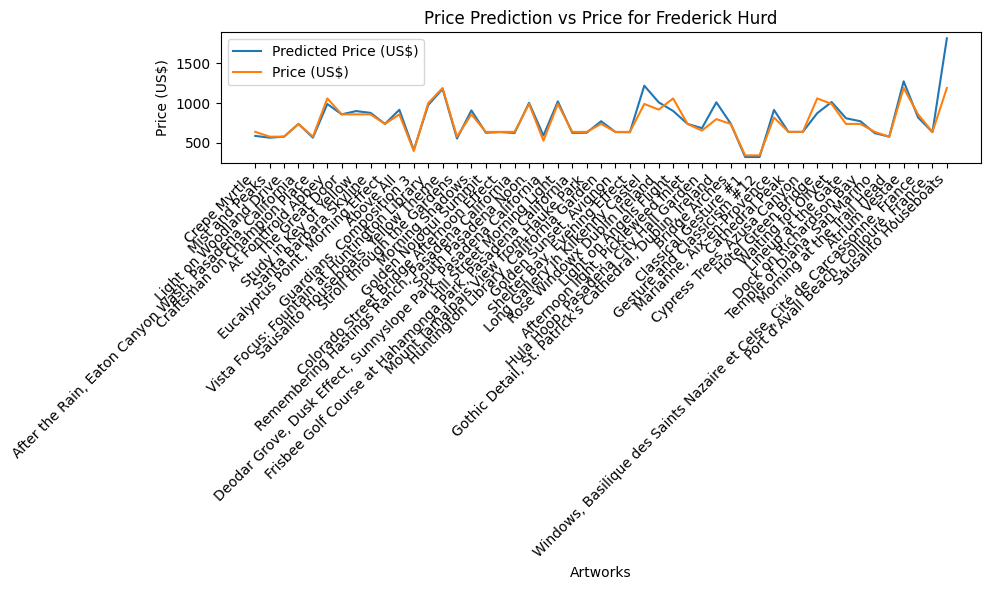

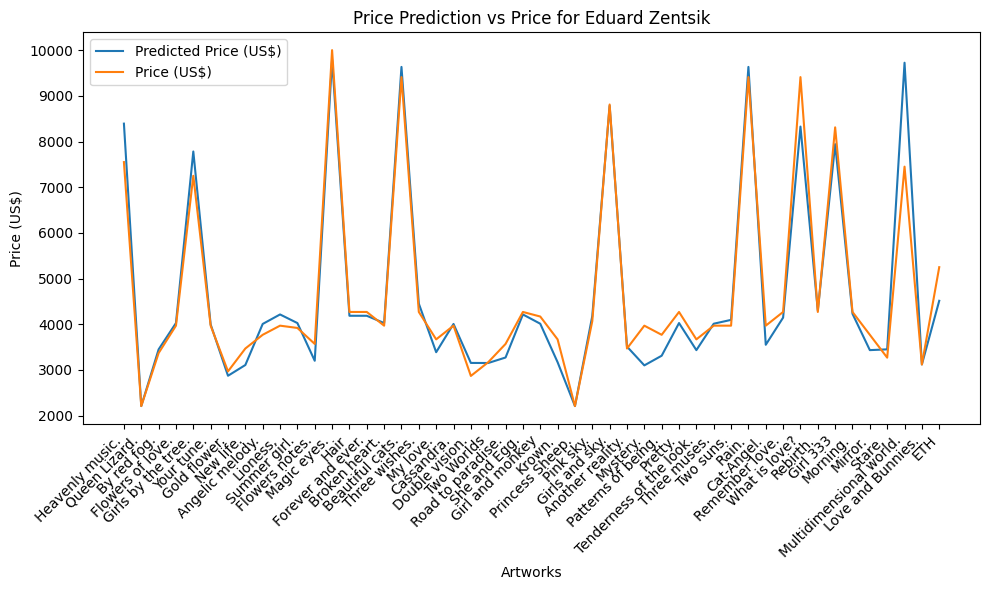

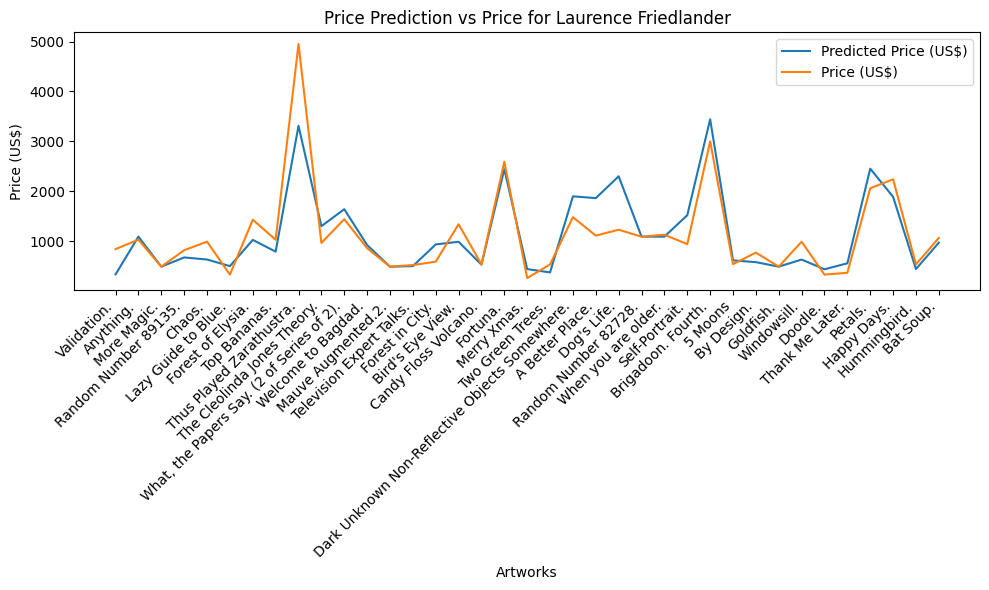

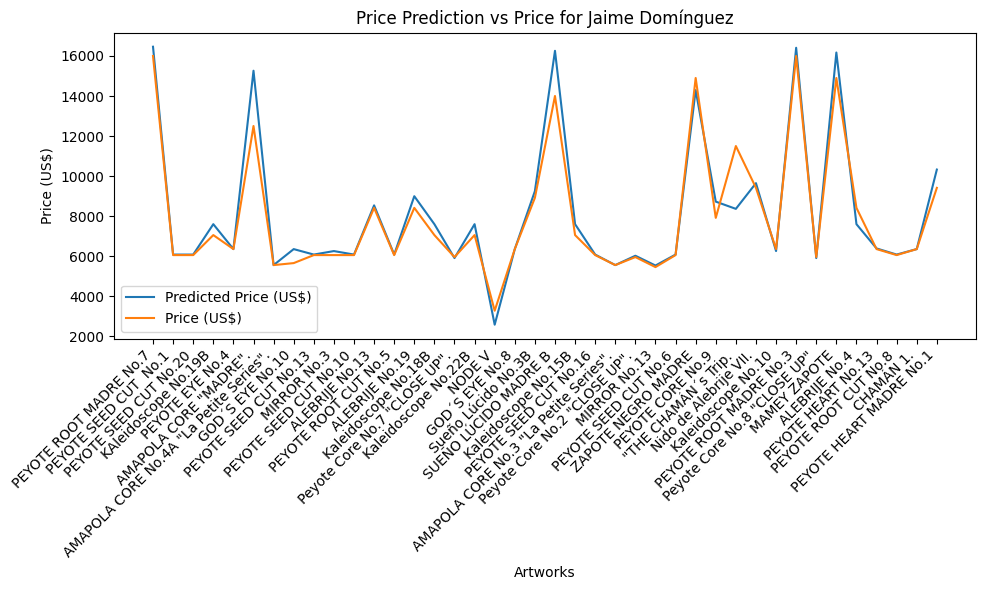

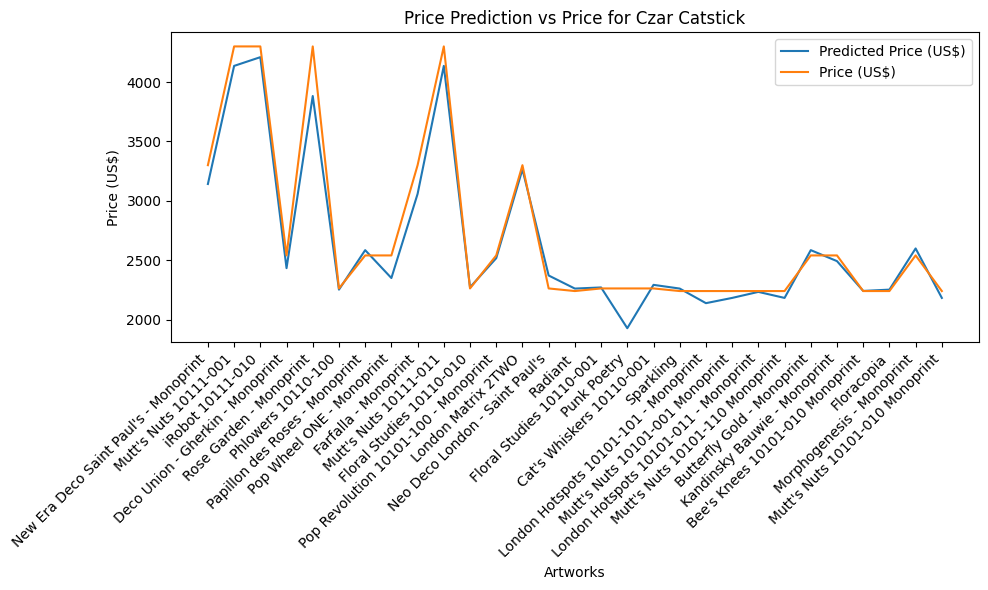

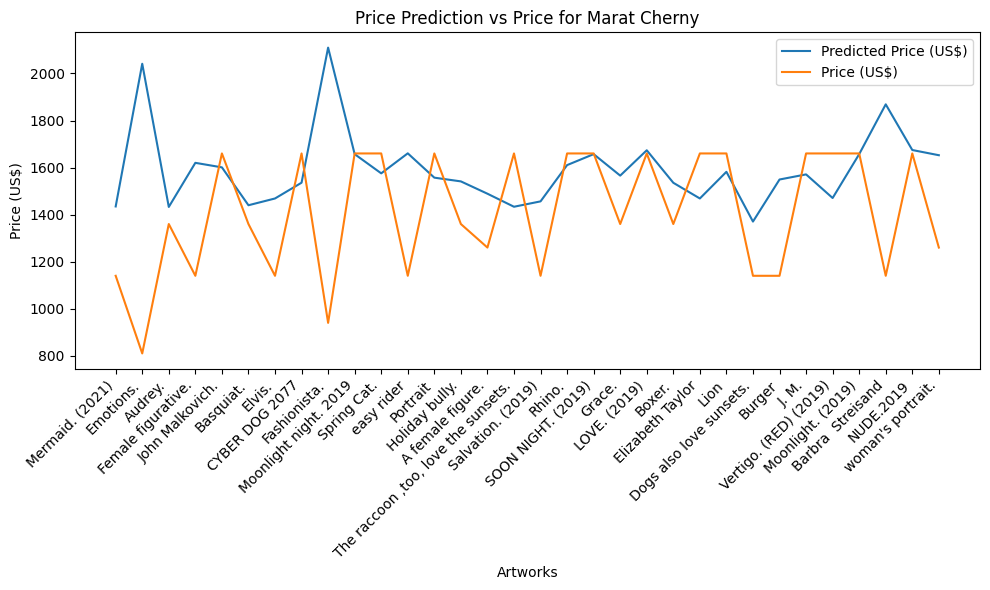

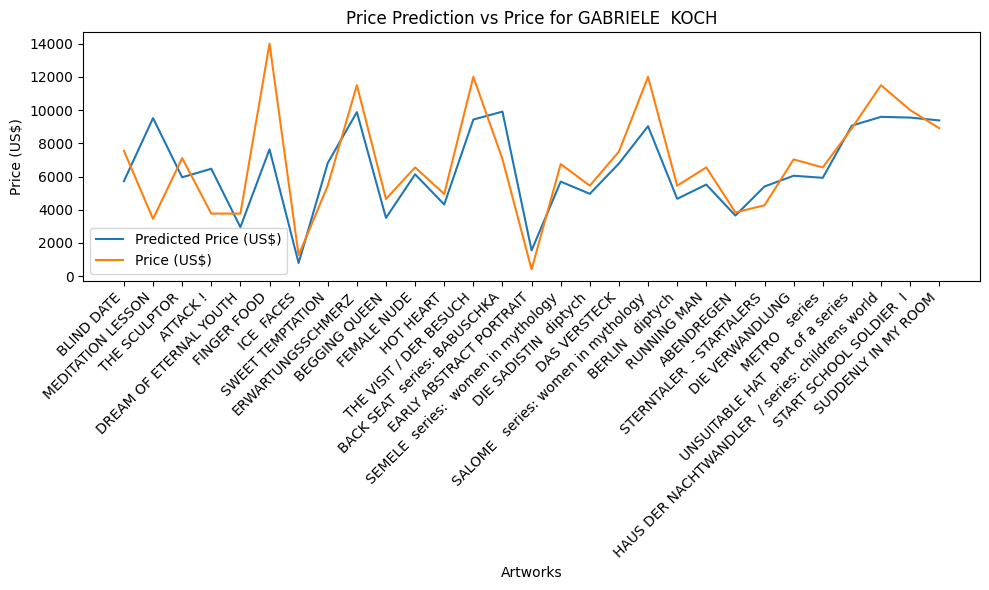

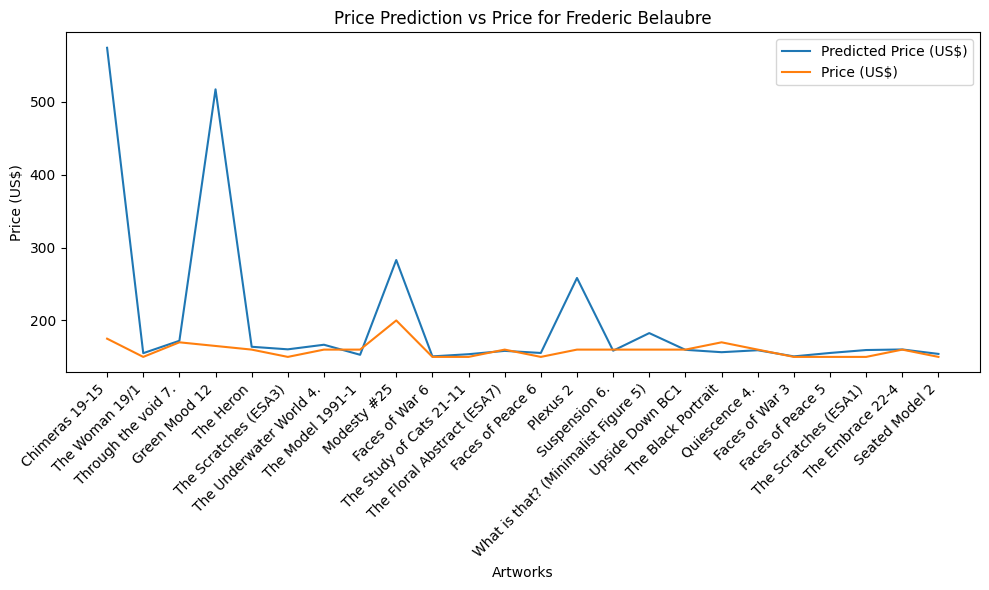

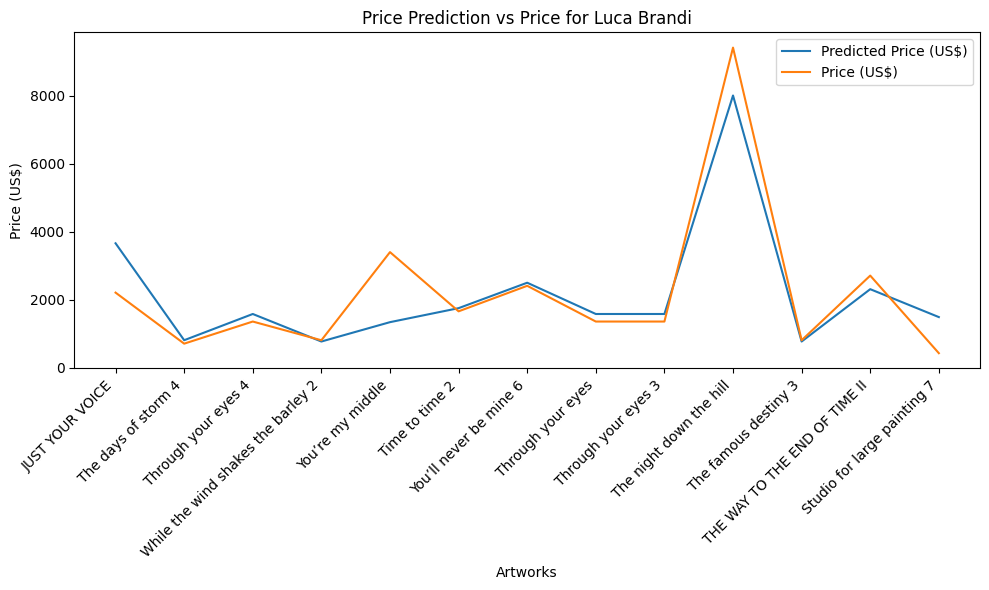



['Frederick Hurd'] size artworks


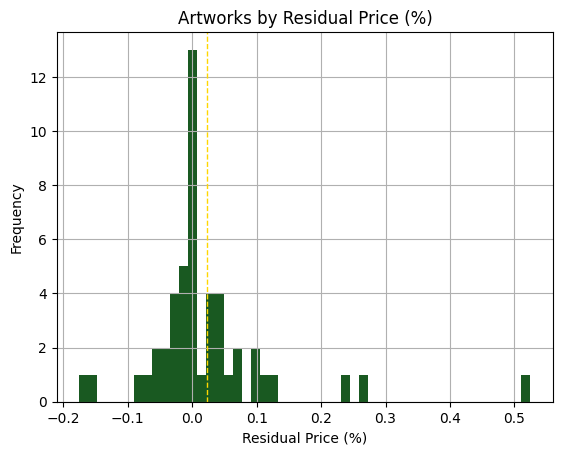

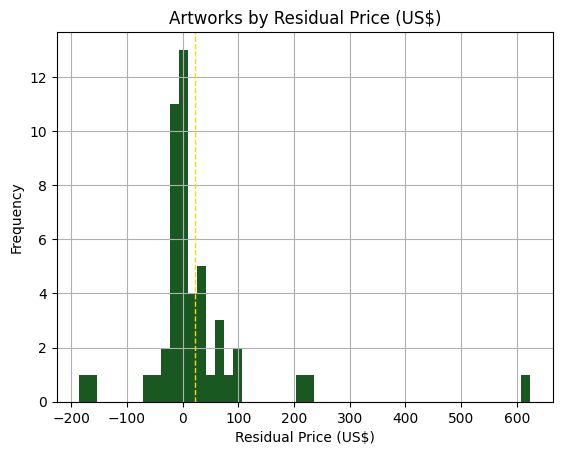

        Residual Price (%)  Residual Price (US$)
max               0.524835            624.553333
min              -0.175052           -185.380000
mean              0.022343             22.850824
median            0.000000              0.000000
stdev             0.104491            109.858766
var               0.010918          12068.948569


['Eduard Zentsik'] size artworks


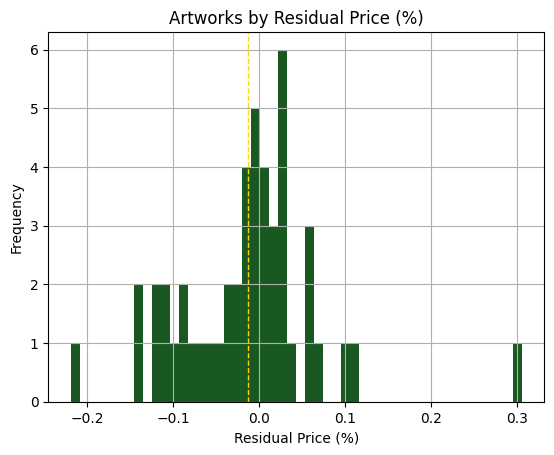

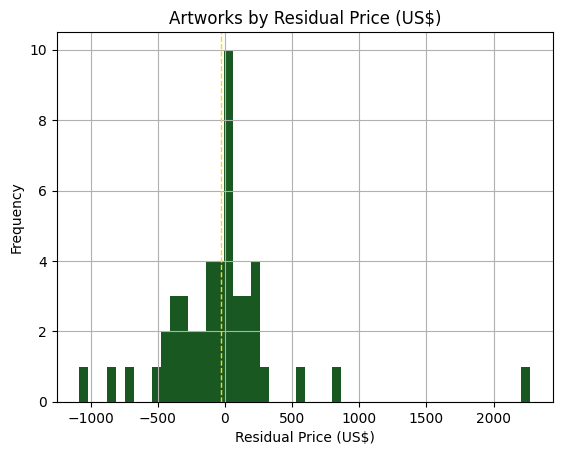

        Residual Price (%)  Residual Price (US$)
max               0.305291           2274.414322
min              -0.218953          -1082.919167
mean             -0.012544            -31.216921
median           -0.001599             -8.541667
stdev             0.081540            473.807152
var               0.006649         224493.217305


['Laurence Friedlander'] size artworks


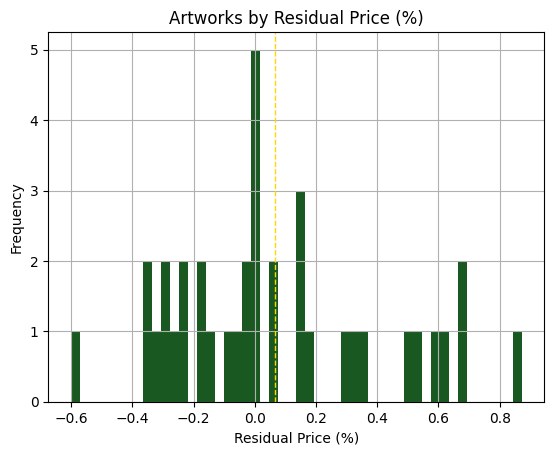

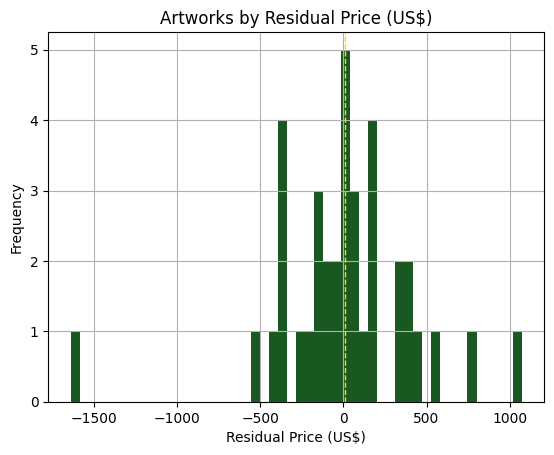

        Residual Price (%)  Residual Price (US$)
max               0.871660           1071.270000
min              -0.601687          -1638.130000
mean              0.066615              7.618064
median            0.000000              0.000000
stdev             0.349171            433.164496
var               0.121920         187631.480947


['Jaime Domínguez'] size artworks


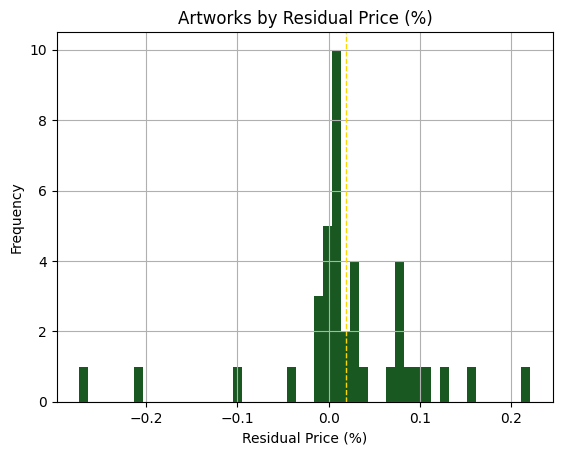

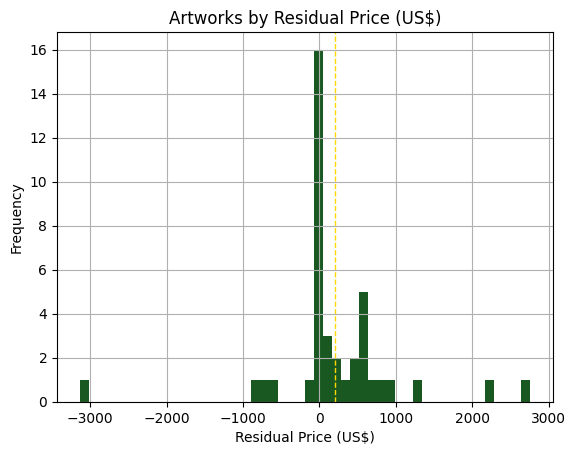

        Residual Price (%)  Residual Price (US$)
max               0.221052           2763.150000
min              -0.273007          -3139.584762
mean              0.018615            204.630301
median            0.004793             29.783202
stdev             0.083085            850.424451
var               0.006903         723221.746642


['Czar Catstick'] size artworks


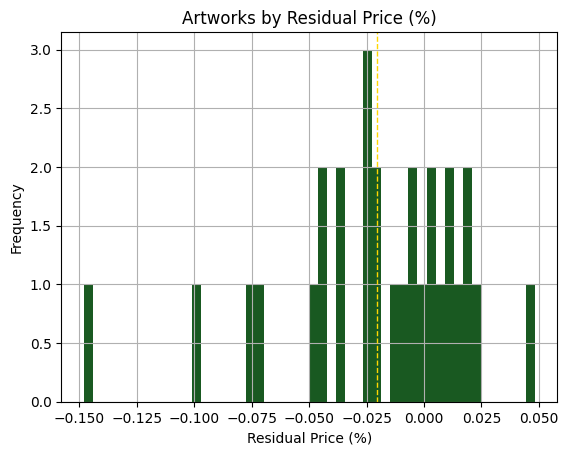

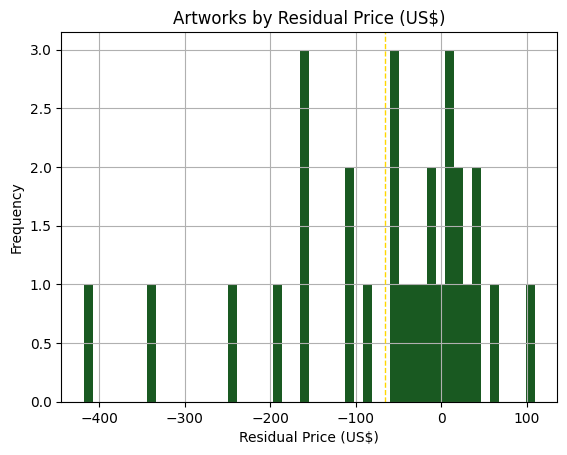

        Residual Price (%)  Residual Price (US$)
max               0.048196            109.020000
min              -0.148046           -417.720000
mean             -0.020613            -65.775691
median           -0.010727            -35.400000
stdev             0.040528            119.594726
var               0.001643          14302.898526


['Marat Cherny'] size artworks


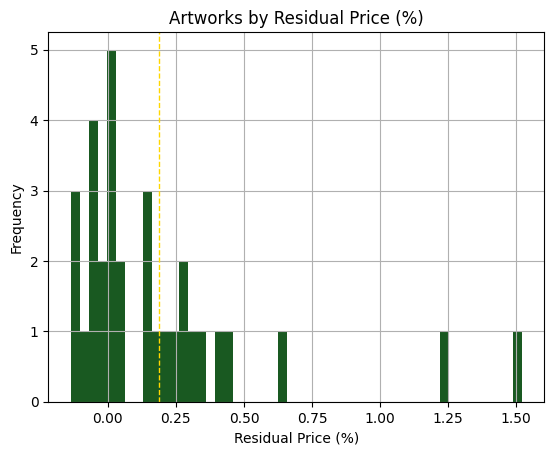

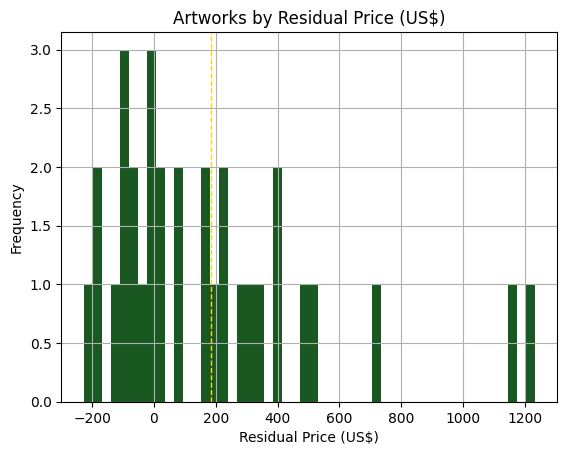

        Residual Price (%)  Residual Price (US$)
max               1.519975           1231.180000
min              -0.136486           -226.566667
mean              0.186774            183.420538
median            0.056052             76.230595
stdev             0.367708            352.717155
var               0.135209         124409.391594


['GABRIELE  KOCH'] size artworks


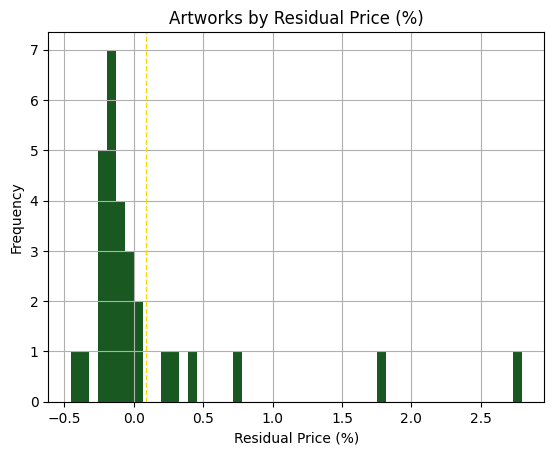

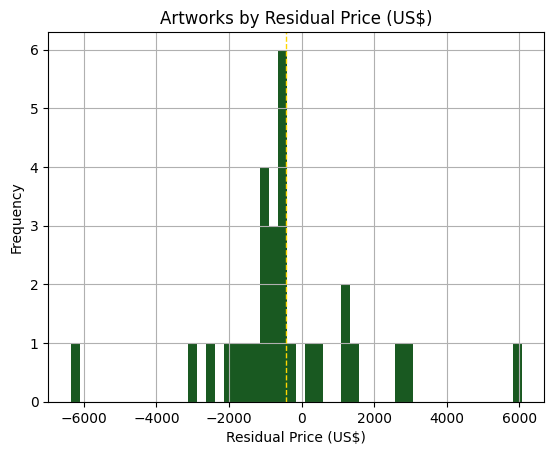

        Residual Price (%)  Residual Price (US$)
max               2.794146          6.066020e+03
min              -0.454507         -6.363100e+03
mean              0.090821         -4.254387e+02
median           -0.127747         -6.323500e+02
stdev             0.662846          2.125212e+03
var               0.439364          4.516527e+06


['Frederic Belaubre'] size artworks


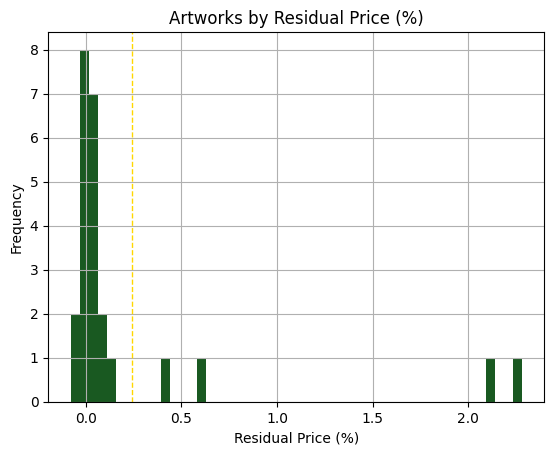

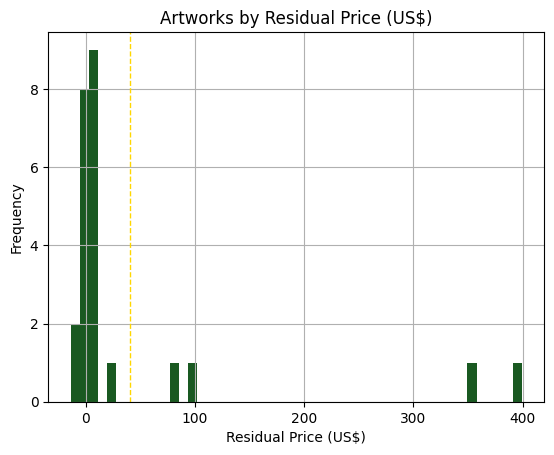

        Residual Price (%)  Residual Price (US$)
max               2.279880            398.978929
min              -0.079706            -13.550000
mean              0.242111             41.144980
median            0.026000              4.000000
stdev             0.623297            106.342026
var               0.388499          11308.626568


['Luca Brandi'] size artworks


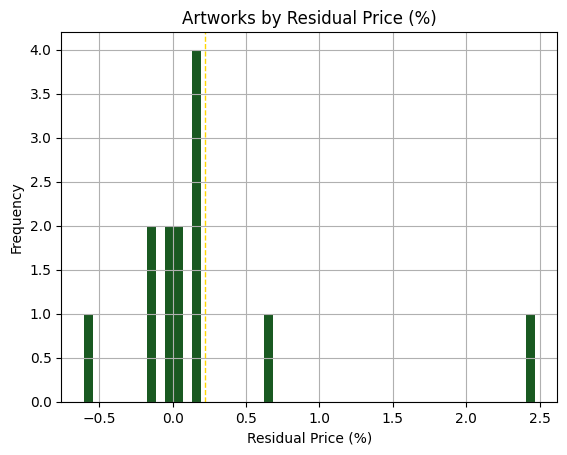

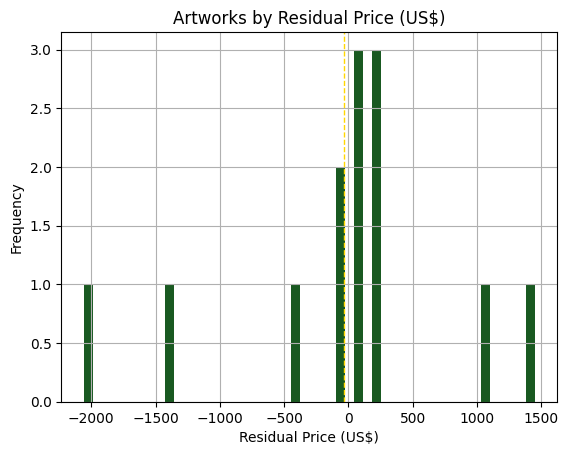

        Residual Price (%)  Residual Price (US$)
max               2.466977           1449.610000
min              -0.605353          -2058.200000
mean              0.219629            -36.711078
median            0.056219             93.322878
stdev             0.730785            901.964295
var               0.534047         813539.588999


In [37]:
## CASE STUDIES: SELECTED ARTISTS

# Select model
model = models[model_name]

# Select artists
selected_artists = artworks['Artist'].value_counts().head(9).index

artists_names = selected_artists
print(artists_names)

artists_indices = []
for artist_name in artists_names:
    artist_name = artist_name[0]
    artist_indices = test_dummies[test_dummies[artist_name] == True].index
    artists_indices.append(artist_indices)

    artist_dummies = test_dummies.loc[artist_indices]
    artist_dummies['Title'] = artworks.loc[artist_indices]['Title']
    
    # Assuming artist_arworks_dummies is your DataFrame
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plotting Price Prediction and Price against Artwork Titles
    ax.plot(artist_dummies['Title'], artist_dummies['Predicted Price (US$)'], label='Predicted Price (US$)')
    ax.plot(artist_dummies['Title'], artist_dummies['Price (US$)'], label='Price (US$)')
    # Rotating x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")
    ax.set_xlabel('Artworks')
    ax.set_ylabel('Price (US$)')
    ax.set_title('Price Prediction vs Price for {}'.format(artist_name))
    ax.legend()
    plt.tight_layout()  # To ensure labels and titles fit properly
    plt.show()


case_study(test_dummies, artists_indices, artists_names)

In [38]:
## APPLYING MODELS TO SEGMENTS

# multi variate linear regression with price as y and all segments as x
x = test_dummies.drop(['Price (US$)', column_name], axis=1)
# dependent variable
y = test_dummies['Price (US$)']

print('Models for',column_name ,'x','Price (US$)')
get_all_models(x, y)
print()
print(test_dummies.columns)

Models for Price (US$) x Price (US$)


TypeError: get_all_models() missing 2 required positional arguments: 'y_train' and 'y_test'

In [ ]:
# ## COMPARE SEGMENTS:

# artworks_data = get_artworks_df()
# ## COLUMN CHOSEN TO DEFINE SEGMENTS
# column_name = 'Styles'
# column = artworks_data.Styles
# occurrences_threshold = 0

# print('IN EACH LISTED SEGMENT, HOW STRONGLY DOES THE PRICE OF AN ARTWORK DEPEND ON ITS SIZE?')
# print()


# segments_dfs = group_by_segments(artworks_data, column_name, column, occurrences_threshold)


# segments_to_compare = ['Impressionism', 'Photorealism']

# # Variables
# x_column_name = 'Size (in²)'
# y_column_name = 'Price (US$)'

# filtered_artworks_data = artworks_data[artworks_data[column_name].apply(lambda x: any(item in x for item in segments_to_compare))]

# compare_segments(filtered_artworks_data, segments_to_compare, x_column_name, y_column_name)

In [ ]:
## FIND BETA OF FEATURES 

x_beta_dummies = test_dummies.drop(columns=['Residual Price (%)', 'Residual Price (US$)', 'Predicted Price (US$)', 'Price (US$/in²)', 'Price (US$)'])
y_beta_dummies = test_dummies['Predicted Price (US$)']

linear_regression = get_linear_regression(x_beta_dummies, y_beta_dummies)

beta_df = pd.DataFrame(linear_regression.coef_, index=x_beta_dummies.columns, columns=['Beta']).sort_values('Beta', ascending=False)
beta_df.head(20)

In [ ]:
# get country of each artist

artists = feature_importances_df[feature_importances_df['Category'] == 'Artist'].index.tolist()

artists_countries = pd.DataFrame(columns=['Country'], index=artists)
for artist in artists:
    artist_country = artworks[artworks['Artist'].apply(lambda x: artist in x)].Country.unique().tolist()[0]
    artists_countries.loc[artist, 'Country'] = artist_country

artists_df = feature_importances_df.merge(beta_df, left_index=True, right_index=True)
artists_df = artists_df[artists_df['Category'] == 'Artist']
artists_df = artists_df.merge(artists_countries, left_index=True, right_index=True)
artists_df.sort_values('Beta', ascending=False, inplace=True)
artists_df

In [ ]:
top_artists = artists_df.sort_values('Beta', ascending=False).head(100)
top_artists_countries = list(set(top_artists['Country'].to_list()))

bottom_artists = artists_df.sort_values('Beta', ascending=True).head(100)
top_artists_countries

In [ ]:
countries_df = artists_df.groupby('Country').agg({'Beta': 'mean', 'Feature Importance': 'sum'}).sort_values('Beta', ascending=False)
countries_df
# top_artists_countries = artists_df.sort_values('Beta', ascending=False).head(100).Country.tolist()
# top_artists_countries = artists_df.sort_values('Beta', ascending=False).tail(100).Country.tolist()

# print('Top artists:', top_artists)
# print('Bottom artists:', bottom_artists)